In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from src.data_loading import DlDataset
from src.utils import plot_performance
from src.convnet import do_train_trials, train_net, evaluate_net_classes, NumNet, ModelPerformanceSummary

import matplotlib.pyplot as plt

In [4]:
"""import data for a 1000 pairs"""

N = 1000
dataset = DlDataset(N, normalize=True, upsample=None)
datasetShape = list(dataset.__shape__()[1:])

device = torch.device('cpu') #Hannes' gpu is not supported but has cuda cores... 

"""Train parameters"""

epochs = 15
eta = 5e-2
gamma = 0.2

criterion = torch.nn.CrossEntropyLoss()

optim_spec = {'type':'SGD', 'lr':eta, 'momentum':gamma}
batch_spec = {'batch_size': 100, 'shuffle':True, 'num_workers':4}


** Model architectures **
Number of trainable paramaters should be below 100'000
1. 2 conv layers, 2 batch norm layers, 2 linear layers
2. 2 conv layers, 2 batch norm layers, 2 linear layers, 1 dropout layer
3. 2 conv layers, 2 batch norm layers, 2 linear layers, 1 dropout layer, 1 maxpool layer
4. 3 conv layers, 3 batch norm layers, 2 linear layers
5. 3 conv layers, 3 batch norm layers, 2 linear layers, 1 dropout layer
6. 3 conv layers, 3 batch norm layers, 2 linear layers, 1 dropout layer, 1 maxpool layer

In [5]:
# The same net using NumNet class
def create_models(models, datasetShape, outputShape):

    # 2 convolutional layers followed by 2 linear layers with batch norm after each conv layer
    config_2c_2l_2bn = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
              {'Type': 'BatchNormLayer'},
              {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
              {'Type': 'BatchNormLayer'},
              {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
              {'Type': 'LinearLayer', 'out_features':outputShape}]
    models.append(NumNet(datasetShape, config_2c_2l_2bn, name='2conv_2lin_2bn'))

    # 2 convolutional layers with batch norm and 1 dropout, followed by 2 linear layers 
    config_2c_2l_2bn_1do = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
              {'Type': 'BatchNormLayer'},
              {'Type': 'DropoutLayer', 'p':0.5},
              {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
              {'Type': 'BatchNormLayer'},
              {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
              {'Type': 'LinearLayer', 'out_features':outputShape}]
    models.append(NumNet(datasetShape, config_2c_2l_2bn_1do, name='2conv_2lin_2bn_1do'))

    # 2 convolutional layers with batch norm and 1 maxpool and 1 dropout, followed by 2 linear layers 
    config_2c_2l_2bn_1do_1mp = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
              {'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
              {'Type': 'BatchNormLayer'},
              {'Type': 'DropoutLayer', 'p':0.5},
              {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
              {'Type': 'BatchNormLayer'},
              {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
              {'Type': 'LinearLayer', 'out_features':outputShape}]
    models.append(NumNet(datasetShape, config_2c_2l_2bn_1do_1mp, name='2conv_2lin_2bn_1do_1mp'))

    # 3 convolutional layers followed by 2 linear layers with batch norm after each conv layer
    config_3c_2l_3bn = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
                        {'Type': 'BatchNormLayer'},
                        {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
                        {'Type': 'BatchNormLayer'},
                        {'Type': 'ConvLayer', 'out_channels':32, 'activation':'ReLU()', 'kernel_size':3},
                        {'Type': 'BatchNormLayer'},
                        {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
                        {'Type': 'LinearLayer', 'out_features':outputShape}]
    models.append(NumNet(datasetShape, config_3c_2l_3bn, name='3conv_2lin_3bn'))

    # 3 convolutional layers followed by 2 linear layers with batch norm after each conv layer and 1 dropout
    config_3c_2l_3bn_1do = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
                            {'Type': 'BatchNormLayer'},
                            {'Type': 'DropoutLayer', 'p':0.5},
                            {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
                            {'Type': 'BatchNormLayer'},
                            {'Type': 'ConvLayer', 'out_channels':32, 'activation':'ReLU()', 'kernel_size':3},
                            {'Type': 'BatchNormLayer'},
                            {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
                            {'Type': 'LinearLayer', 'out_features':outputShape}]
    models.append(NumNet(datasetShape, config_3c_2l_3bn_1do, name='3conv_2lin_3bn_1do'))

    # 3 convolutional layers followed by 2 linear layers with batch norm after each conv layer and 1 dropout
    config_3c_2l_3bn_1do_1mp = [{'Type': 'ConvLayer', 'out_channels':8, 'activation':'ReLU()', 'kernel_size':5},
                                {'Type': 'MaxPoolLayer', 'pooling':2, 'stride':2},
                                {'Type': 'BatchNormLayer'},
                                {'Type': 'DropoutLayer', 'p':0.5},
                                {'Type': 'ConvLayer', 'out_channels':16, 'activation':'ReLU()', 'kernel_size':3},
                                {'Type': 'BatchNormLayer'},
                                {'Type': 'ConvLayer', 'out_channels':32, 'activation':'ReLU()', 'kernel_size':3},
                                {'Type': 'BatchNormLayer'},
                                {'Type': 'LinearLayer', 'out_features':32, 'activation':'ReLU()'},
                                {'Type': 'LinearLayer', 'out_features':outputShape}]
    models.append(NumNet(datasetShape, config_3c_2l_3bn_1do_1mp, name='3conv_2lin_3bn_1do_1mp'))

    for model in models:
        model.summary()
        

# Training for the boolean target

In [6]:
# Prepare dataloader
dataloader = []
for mode in ['train','test']:
    if mode == 'train':
        dataset.train()
    elif mode == 'test':
        dataset.test()
    dataloader.append(dataset.return_dataloader(**batch_spec))

# create models
models = []
outputShape = 2
create_models(models, datasetShape, outputShape)

 
Model '2conv_2lin_2bn'
Number              Layer               Input shape         Output shape        Trainable params    
0                   Conv2d              [2, 14, 14]         [8, 10, 10]         408
1                   BatchNorm2d         [8, 10, 10]         [8, 10, 10]         16
2                   Conv2d              [8, 10, 10]         [16, 8, 8]          1168
3                   BatchNorm2d         [16, 8, 8]          [16, 8, 8]          32
4                   Linear              1024                32                  32800
5                   Linear              32                  2                   66
----------------------------------------------------------------------------------------------------
Total number of trainable parameters: 34490
----------------------------------------------------------------------------------------------------
 
Model '2conv_2lin_2bn_1do'
Number              Layer               Input shape         Output shape        Trainable param

** Multiple training trials using the 'do_train_trials' function: **

In [7]:
trial_summaries = []
for model in models:
    print("-"*100)
    print("Running model: {}".format(model.name()))
    print("-"*100)

    
    performance = do_train_trials(10, model, device, optim_spec, criterion, dataset, batch_spec,
                                    epochs=epochs, lambda_=1e-3, reg_type=None, 
                                    save=False)
    trial_summaries.append(performance)



----------------------------------------------------------------------------------------------------
Running model: 2conv_2lin_2bn
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Trial: 0
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.38s, Train Loss: 6.24e-03, Train Acc: 0.66, Val Loss: 5.00e-03, Val Acc: 0.78
Epoch 1: Duration: 0.37s, Train Loss: 4.40e-03, Train Acc: 0.80, Val Loss: 3.91e-03, Val Acc: 0.85
Epoch 2: Duration: 0.41s, Train Loss: 3.76e-03, Train Acc: 0.84, Val Loss: 3.55e-03, Val Acc: 0.85
Epoch 3: Duration: 0.40s, Train Loss: 3.31e-03, Train Acc: 0.87, Val Loss: 2.86e-03, Val Acc: 0.91
Epoch 4: Duration: 0.42s, Train Loss: 3.05e-03, Train Acc: 0.89, Val Loss: 2.65e-03, Val Acc: 0.91
Epoch 5: Duration: 0.39s, Train Loss: 2.61e-03, Train 

----------------------------------------------------------------------------------------------------
Running Trial: 0
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.35s, Train Loss: 7.17e-03, Train Acc: 0.55, Val Loss: 6.40e-03, Val Acc: 0.65
Epoch 1: Duration: 0.35s, Train Loss: 6.51e-03, Train Acc: 0.61, Val Loss: 5.93e-03, Val Acc: 0.70
Epoch 2: Duration: 0.37s, Train Loss: 6.16e-03, Train Acc: 0.66, Val Loss: 5.48e-03, Val Acc: 0.75
Epoch 3: Duration: 0.36s, Train Loss: 5.70e-03, Train Acc: 0.71, Val Loss: 5.19e-03, Val Acc: 0.76
Epoch 4: Duration: 0.35s, Train Loss: 5.48e-03, Train Acc: 0.73, Val Loss: 4.98e-03, Val Acc: 0.77
Epoch 5: Duration: 0.37s, Train Loss: 5.40e-03, Train Acc: 0.71, Val Loss: 4.91e-03, Val Acc: 0.78
Epoch 6: Duration: 0.36s, Train Loss: 5.09e-03, Train Acc: 0.74, Val Loss: 4.77e-03, Val Acc: 0.80
Epoch 7: Duration: 0.37s, Train Loss: 5.26e-03, Train Acc: 0.73, Val Loss: 4.51e-03, Val

----------------------------------------------------------------------------------------------------
Running Trial: 0
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.47s, Train Loss: 7.21e-03, Train Acc: 0.56, Val Loss: 6.35e-03, Val Acc: 0.70
Epoch 1: Duration: 0.48s, Train Loss: 6.00e-03, Train Acc: 0.66, Val Loss: 5.70e-03, Val Acc: 0.77
Epoch 2: Duration: 0.41s, Train Loss: 5.50e-03, Train Acc: 0.73, Val Loss: 5.07e-03, Val Acc: 0.79
Epoch 3: Duration: 0.42s, Train Loss: 5.13e-03, Train Acc: 0.74, Val Loss: 4.31e-03, Val Acc: 0.82
Epoch 4: Duration: 0.43s, Train Loss: 4.82e-03, Train Acc: 0.76, Val Loss: 3.93e-03, Val Acc: 0.82
Epoch 5: Duration: 0.43s, Train Loss: 4.79e-03, Train Acc: 0.75, Val Loss: 3.78e-03, Val Acc: 0.83
Epoch 6: Duration: 0.42s, Train Loss: 4.60e-03, Train Acc: 0.77, Val Loss: 3.79e-03, Val Acc: 0.83
Epoch 7: Duration: 0.43s, Train Loss: 4.38e-03, Train Acc: 0.79, Val Loss: 3.49e-03, Val

Model: 2conv_2lin_2bn        avg_train_loss       min: 0.001 max: 0.006 std: 0.0000
Model: 2conv_2lin_2bn        avg_test_loss        min: 0.001 max: 0.005 std: 0.0002
Model: 2conv_2lin_2bn        avg_train_accuracy   min: 0.646 max: 0.991 std: 0.0042
Model: 2conv_2lin_2bn        avg_test_accuracy    min: 0.754 max: 0.993 std: 0.0148
Model: 2conv_2lin_2bn_1do    avg_train_loss       min: 0.004 max: 0.007 std: 0.0002
Model: 2conv_2lin_2bn_1do    avg_test_loss        min: 0.003 max: 0.006 std: 0.0003
Model: 2conv_2lin_2bn_1do    avg_train_accuracy   min: 0.597 max: 0.832 std: 0.0212
Model: 2conv_2lin_2bn_1do    avg_test_accuracy    min: 0.730 max: 0.897 std: 0.0170
Model: 2conv_2lin_2bn_1do_1mp  avg_train_loss       min: 0.005 max: 0.007 std: 0.0000
Model: 2conv_2lin_2bn_1do_1mp  avg_test_loss        min: 0.004 max: 0.006 std: 0.0001
Model: 2conv_2lin_2bn_1do_1mp  avg_train_accuracy   min: 0.539 max: 0.773 std: 0.0035
Model: 2conv_2lin_2bn_1do_1mp  avg_test_accuracy    min: 0.633 max: 0.

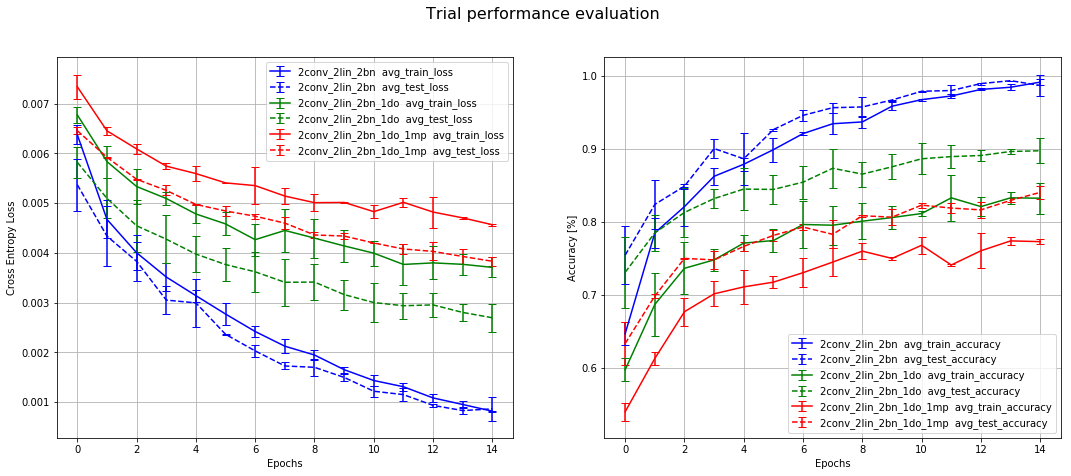

In [8]:
# Plot stuff for 2conv models
plot_this = [[('avg_train_loss','std_train_loss'),('avg_test_loss','std_test_loss')],              [('avg_train_accuracy','std_train_accuracy'),('avg_test_accuracy','std_test_accuracy')]]
axes, extrema = plot_performance(1,trial_summaries[0:3], plot_this, suptitle='Trial performance evaluation Op. 1, 2conv Models')
axes[0].set_ylabel('Cross Entropy Loss')
axes[1].set_ylabel('Accuracy [%]');


# Plot stuff for 3conv models
plot_this = [[('avg_train_loss','std_train_loss'),('avg_test_loss','std_test_loss')],              [('avg_train_accuracy','std_train_accuracy'),('avg_test_accuracy','std_test_accuracy')]]
axes, extrema = plot_performance(2,trial_summaries[3:], plot_this, suptitle='Trial performance evaluation Op. 1, 3conv Models')
axes[0].set_ylabel('Cross Entropy Loss')
axes[1].set_ylabel('Accuracy [%]');

# Training for the digit classes

In [10]:
# Train for digits and not the target.

dataset_digit = DlDataset(N, normalize=True, upsample=None, split_dataset = True)

datasetShape_digit = list(dataset_digit.__shape__()[1:])

** Model architectures **
Number of trainable paramaters should be below 100'000
1. 2 conv layers, 2 batch norm layers, 2 linear layers
2. 2 conv layers, 2 batch norm layers, 2 linear layers, 1 dropout layer
3. 2 conv layers, 2 batch norm layers, 2 linear layers, 1 dropout layer, 1 maxpool layer
4. 3 conv layers, 3 batch norm layers, 2 linear layers
5. 3 conv layers, 3 batch norm layers, 2 linear layers, 1 dropout layer
6. 3 conv layers, 3 batch norm layers, 2 linear layers, 1 dropout layer, 1 maxpool layer

In [13]:
# Prepare dataloader
dataloader = []
for mode in ['train','test']:
    if mode == 'train':
        dataset_digit.train()
    elif mode == 'test':
        dataset_digit.test()
    dataloader.append(dataset_digit.return_dataloader(**batch_spec))

# create models
models_digit = []
outputShape = 10
create_models(models_digit, datasetShape_digit, outputShape)

 
Model '2conv_2lin_2bn'
Number              Layer               Input shape         Output shape        Trainable params    
0                   Conv2d              [1, 14, 14]         [8, 10, 10]         208
1                   BatchNorm2d         [8, 10, 10]         [8, 10, 10]         16
2                   Conv2d              [8, 10, 10]         [16, 8, 8]          1168
3                   BatchNorm2d         [16, 8, 8]          [16, 8, 8]          32
4                   Linear              1024                32                  32800
5                   Linear              32                  10                  330
----------------------------------------------------------------------------------------------------
Total number of trainable parameters: 34554
----------------------------------------------------------------------------------------------------
 
Model '2conv_2lin_2bn_1do'
Number              Layer               Input shape         Output shape        Trainable para

** Multiple training trials using the 'do_train_trials' function: **

In [14]:
trial_summaries_digit = []
for model in models_digit:
    print("-"*100)
    print("Running model: {}".format(model.name()))
    print("-"*100)
    
    performance = do_train_trials(10, model, device, optim_spec, criterion, dataset_digit, batch_spec,
                                    epochs=epochs, lambda_=1e-3, reg_type=None, 
                                    save=False)
    trial_summaries_digit.append(performance)

----------------------------------------------------------------------------------------------------
Running model: 2conv_2lin_2bn
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Running Trial: 0
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.43s, Train Loss: 1.80e-02, Train Acc: 0.39, Val Loss: 1.34e-02, Val Acc: 0.65
Epoch 1: Duration: 0.46s, Train Loss: 7.98e-03, Train Acc: 0.79, Val Loss: 6.04e-03, Val Acc: 0.86
Epoch 2: Duration: 0.44s, Train Loss: 4.58e-03, Train Acc: 0.88, Val Loss: 3.62e-03, Val Acc: 0.92
Epoch 3: Duration: 0.42s, Train Loss: 3.26e-03, Train Acc: 0.92, Val Loss: 2.56e-03, Val Acc: 0.95
Epoch 4: Duration: 0.43s, Train Loss: 2.43e-03, Train Acc: 0.95, Val Loss: 1.98e-03, Val Acc: 0.97
Epoch 5: Duration: 0.43s, Train Loss: 1.94e-03, Train 

----------------------------------------------------------------------------------------------------
Running Trial: 0
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.41s, Train Loss: 2.21e-02, Train Acc: 0.22, Val Loss: 1.99e-02, Val Acc: 0.41
Epoch 1: Duration: 0.38s, Train Loss: 1.87e-02, Train Acc: 0.38, Val Loss: 1.63e-02, Val Acc: 0.55
Epoch 2: Duration: 0.38s, Train Loss: 1.65e-02, Train Acc: 0.48, Val Loss: 1.36e-02, Val Acc: 0.63
Epoch 3: Duration: 0.39s, Train Loss: 1.45e-02, Train Acc: 0.53, Val Loss: 1.15e-02, Val Acc: 0.69
Epoch 4: Duration: 0.40s, Train Loss: 1.28e-02, Train Acc: 0.64, Val Loss: 9.67e-03, Val Acc: 0.75
Epoch 5: Duration: 0.36s, Train Loss: 1.17e-02, Train Acc: 0.64, Val Loss: 8.35e-03, Val Acc: 0.78
Epoch 6: Duration: 0.37s, Train Loss: 1.03e-02, Train Acc: 0.70, Val Loss: 7.30e-03, Val Acc: 0.81
Epoch 7: Duration: 0.36s, Train Loss: 9.18e-03, Train Acc: 0.74, Val Loss: 6.22e-03, Val

----------------------------------------------------------------------------------------------------
Running Trial: 0
----------------------------------------------------------------------------------------------------
Epoch 0: Duration: 0.55s, Train Loss: 2.12e-02, Train Acc: 0.26, Val Loss: 1.73e-02, Val Acc: 0.53
Epoch 1: Duration: 0.51s, Train Loss: 1.47e-02, Train Acc: 0.54, Val Loss: 1.13e-02, Val Acc: 0.79
Epoch 2: Duration: 0.56s, Train Loss: 1.11e-02, Train Acc: 0.70, Val Loss: 7.40e-03, Val Acc: 0.85
Epoch 3: Duration: 0.63s, Train Loss: 8.70e-03, Train Acc: 0.78, Val Loss: 5.28e-03, Val Acc: 0.87
Epoch 4: Duration: 0.59s, Train Loss: 6.76e-03, Train Acc: 0.81, Val Loss: 4.16e-03, Val Acc: 0.90
Epoch 5: Duration: 0.59s, Train Loss: 5.58e-03, Train Acc: 0.85, Val Loss: 3.33e-03, Val Acc: 0.92
Epoch 6: Duration: 0.61s, Train Loss: 5.08e-03, Train Acc: 0.86, Val Loss: 2.79e-03, Val Acc: 0.92
Epoch 7: Duration: 0.61s, Train Loss: 4.43e-03, Train Acc: 0.88, Val Loss: 2.34e-03, Val

Model: 2conv_2lin_2bn        avg_train_loss       min: 0.001 max: 0.019 std: 0.0001
Model: 2conv_2lin_2bn        avg_test_loss        min: 0.000 max: 0.015 std: 0.0001
Model: 2conv_2lin_2bn        avg_train_target_accuracy min: 0.796 max: 0.967 std: 0.0071
Model: 2conv_2lin_2bn        avg_test_target_accuracy min: 0.744 max: 0.969 std: 0.0042
Model: 2conv_2lin_2bn_1do    avg_train_loss       min: 0.003 max: 0.021 std: 0.0005
Model: 2conv_2lin_2bn_1do    avg_test_loss        min: 0.002 max: 0.018 std: 0.0004
Model: 2conv_2lin_2bn_1do    avg_train_target_accuracy min: 0.674 max: 0.941 std: 0.0021
Model: 2conv_2lin_2bn_1do    avg_test_target_accuracy min: 0.741 max: 0.956 std: 0.0049
Model: 2conv_2lin_2bn_1do_1mp  avg_train_loss       min: 0.006 max: 0.022 std: 0.0010
Model: 2conv_2lin_2bn_1do_1mp  avg_test_loss        min: 0.004 max: 0.020 std: 0.0008
Model: 2conv_2lin_2bn_1do_1mp  avg_train_target_accuracy min: 0.622 max: 0.877 std: 0.0318
Model: 2conv_2lin_2bn_1do_1mp  avg_test_target_

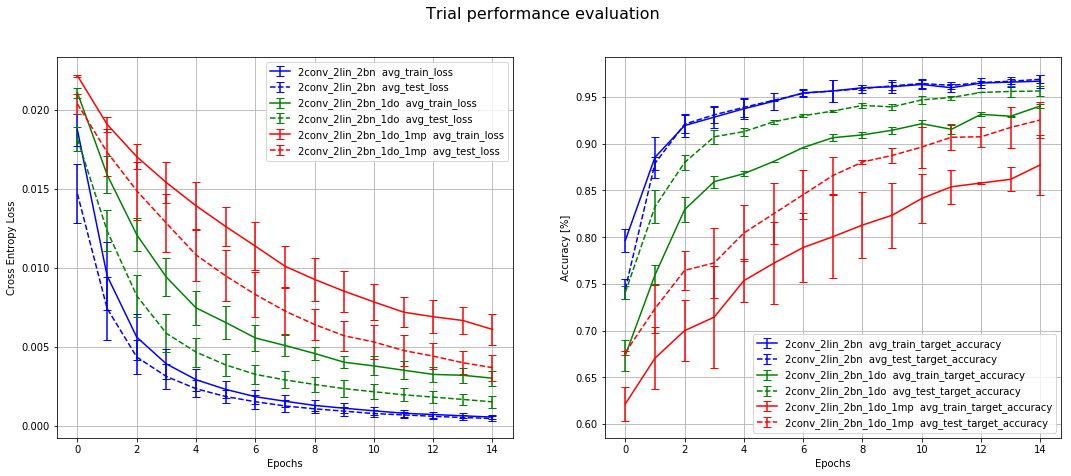

In [15]:
# Plot stuff for 2conv models
plot_this = [[('avg_train_loss','std_train_loss'),('avg_test_loss','std_test_loss')],              [('avg_train_target_accuracy','std_train_target_accuracy'),('avg_test_target_accuracy','std_test_target_accuracy')]]
axes, extrema = plot_performance(3,trial_summaries_digit[0:3], plot_this, suptitle='Trial performance evaluation Op. 2, 2conv Models')
axes[0].set_ylabel('Cross Entropy Loss')
axes[1].set_ylabel('Accuracy [%]');


# Plot stuff for 3conv models
plot_this = [[('avg_train_loss','std_train_loss'),('avg_test_loss','std_test_loss')],              [('avg_train_target_accuracy','std_train_target_accuracy'),('avg_test_target_accuracy','std_test_target_accuracy')]]
axes, extrema = plot_performance(4,trial_summaries_digit[3:], plot_this, suptitle='Trial performance evaluation Op. 2, 3conv Models')
axes[0].set_ylabel('Cross Entropy Loss')
axes[1].set_ylabel('Accuracy [%]');


In [ ]:
#show all plots
plt.show()